In [1]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
import cv2
import os
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from art.attacks.evasion import FastGradientMethod
from art.estimators.classification import KerasClassifier
from art.attacks.poisoning import PoisoningAttackAdversarialEmbedding
from art.attacks.poisoning import PoisoningAttackBackdoor
from art.attacks.poisoning import PoisoningAttackCleanLabelBackdoor
from art.attacks.poisoning.perturbations.image_perturbations import add_pattern_bd, add_single_bd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve

In [2]:
labels = ['Damaged cars', 'Undamaged cars']
img_size = 512

def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1]
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

train = get_data('/home/idebnat/FoolAI/train')
test = get_data('/home/idebnat/FoolAI/test')

x_train = []
y_train = []
x_test = []
y_test = []

for feature, label in train:
  x_train.append(feature)
  y_train.append(label)

for feature, label in test:
  x_test.append(feature)
  y_test.append(label)


x_train = np.array(x_train)/255
x_test = np.array(x_test)/255

x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, shuffle=True, random_state=42)

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

'NoneType' object is not subscriptable


/software/spackages/linux-centos8-x86_64/gcc-8.3.1/anaconda3-2019.10-v5cuhr6keyz5ryxcwvv2jkzfj2gwrj4a/lib/python3.7/site-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  app.launch_new_instance()


'NoneType' object is not subscriptable


In [3]:
model = Sequential()
model.add(Conv2D(32, 4,padding="same", activation="relu", input_shape=(img_size,img_size,3)))
model.add(MaxPool2D())

model.add(Conv2D(32, 4, padding="same", activation="relu"))
model.add(MaxPool2D())

model.add(Conv2D(32, 4, padding="same", activation="relu"))
model.add(MaxPool2D())

model.add(Conv2D(64, 4, padding="same", activation="relu"))
model.add(MaxPool2D())
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128,activation="relu", kernel_regularizer=l2(0.01)))
model.add(Dense(64,activation="relu", kernel_regularizer=l2(0.001)))
model.add(Dense(32,activation="relu"))
model.add(Dense(1, activation="sigmoid"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 512, 512, 32)      1568      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 256, 256, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 32)      16416     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 128, 128, 32)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 32)      16416     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 64, 64, 32)       0

In [4]:
opt = Adam(learning_rate=5e-5)
model.compile(optimizer = opt , loss="binary_crossentropy" , metrics = ['accuracy', 'AUC'])
ep=25

In [5]:
pa_classifier = KerasClassifier(model=model, clip_values=(0, 1), use_logits=False)
pert_attack=PoisoningAttackBackdoor(add_pattern_bd)

PA=PoisoningAttackCleanLabelBackdoor(proxy_classifier=pa_classifier, backdoor= pert_attack, target=np.array([1]), pp_poison=0.99)
x_train_undam=x_train[y_train==1]
y_train_undam=y_train[y_train==1]

x_p, y_p=PA.poison(x_train_undam, y_train_undam.reshape(-1,1))
y_p=y_p.reshape(1,-1)
x_train_new=np.concatenate([x_train[y_train==0], x_p])
y_train_new=np.concatenate([y_train[y_train==0], y_p.flatten()])

pa_classifier.fit(x_train_new, y_train_new, batch_size=32, nb_epochs=ep, validation_data=(x_val,y_val))
predictions = pa_classifier.predict(x_test)
accuracy = np.sum(np.where(predictions>0.5,1,0).reshape(1,-1) == y_test)/len(y_test)
print("Accuracy on test examples: {}%".format(accuracy * 100))


/home/idebnat/software/venv/tf_gpu/lib/python3.7/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,



Train on 160 samples, validate on 40 samples
Epoch 1/25
160/160 [==============================] - ETA: 0s - loss: 3.5984 - accuracy: 0.2750 - AUC: 0.3372

/home/idebnat/software/venv/tf_gpu/lib/python3.7/site-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


160/160 [==============================] - 44s 276ms/sample - loss: 3.5984 - accuracy: 0.2750 - AUC: 0.3372 - val_loss: 3.2275 - val_accuracy: 0.4750 - val_AUC: 0.8421
Epoch 2/25
160/160 [==============================] - 42s 262ms/sample - loss: 3.1243 - accuracy: 0.5063 - AUC: 0.8773 - val_loss: 3.1273 - val_accuracy: 0.4750 - val_AUC: 0.8333
Epoch 3/25
160/160 [==============================] - 43s 269ms/sample - loss: 2.9878 - accuracy: 0.5063 - AUC: 0.8881 - val_loss: 3.0073 - val_accuracy: 0.4750 - val_AUC: 0.8195
Epoch 4/25
160/160 [==============================] - 43s 268ms/sample - loss: 2.8410 - accuracy: 0.5125 - AUC: 0.9142 - val_loss: 2.8916 - val_accuracy: 0.4750 - val_AUC: 0.7757
Epoch 5/25
160/160 [==============================] - 43s 267ms/sample - loss: 2.6971 - accuracy: 0.6687 - AUC: 0.9048 - val_loss: 2.7907 - val_accuracy: 0.5500 - val_AUC: 0.6591
Epoch 6/25
160/160 [==============================] - 43s 266ms/sample - loss: 2.5642 - accuracy: 0.8313 - AUC: 0.91

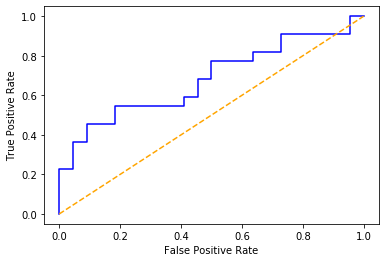

In [6]:
auc=roc_auc_score(y_test, predictions)
fpr, tpr, thresholds = roc_curve(y_test, predictions)
plt.plot(fpr,tpr, color="blue")
plt.plot([0, 1], [0, 1], color="orange", linestyle="--")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()